# v1.1: Example 2 State Dependent Custom Injections

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
import astropy.units as u
import astropy.constants as c

sys.path.append("../..")
from darkhistory.main import evolve
from darkhistory.config import load_data
from darkhistory.spec.spectrum import Spectrum

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../matplotlibrc_nntf")

## Toy example

Consider an injection scenario where the injected photon power is proportional to the current temperature of the universe (for some reason).

In [ ]:
# Since our injection is not event based, we can choose any injection event rate `rate_func_N`,
# so long as the product of `rate_func_N` [injection event / pcm^3 s] and `in_spec_phot`
# [phot / injection event] remains the same.

def inj_rate(z_start, z_end=None, **kwargs): # kwargs allows passing of the state argument.
    return 3.1415927 # any number will do.

def inj_power(z_start, z_end=None, state=None, **kwargs):
    k = 5e-13 # [(eV/pcm^3/s) / eV] | pcm stands for physical cm.
    return k * state['Tm'] # [eV/pcm^3/s]

# Toy delta photon spectrum
photE = load_data('binning')['photeng']
dNdE = np.zeros_like(photE)
E = 1000 # [eV]
i = np.argmin(np.abs(photE - E))
dNdE[i] = 1 # [phot / eV]
fixed_phot_spec = Spectrum(photE, dNdE, spec_type='dNdE')
fixed_phot_spec = fixed_phot_spec / fixed_phot_spec.toteng() # [spectrum / eV (total energy)]

# Zero electron spectrum
elecEk = load_data('binning')['eleceng']
fixed_elec_spec = Spectrum(elecEk, elecEk*0, spec_type='dNdE')

def inj_phot_spec(z_start, z_end=None, **kwargs):
    """Injected photon spectrum density [phot / (eV) pcm^3 s]."""
    return fixed_phot_spec * inj_power(z_start, z_end, **kwargs)

def inj_elec_spec(z_start, z_end=None, **kwargs):
    """Injected electron spectrum density [elec / (eV) pcm^3 s]."""
    return fixed_elec_spec * inj_power(z_start, z_end, **kwargs)

In [3]:
# Convert to rs and per injection functions

def input_in_spec_phot(rs, next_rs=None, dt=None, state=None):
    """Injected photon spectrum per injection event [phot / inj]."""
    z_end = next_rs - 1 if next_rs is not None else None
    return inj_phot_spec(rs-1, z_end=z_end, state=state) / inj_rate(rs-1, z_end=z_end, state=state)

def input_in_spec_elec(rs, next_rs=None, dt=None, state=None):
    """Injected electron spectrum per injection event [elec / inj]."""
    z_end = next_rs - 1 if next_rs is not None else None
    return inj_elec_spec(rs-1, z_end=z_end, state=state) / inj_rate(rs-1, z_end=z_end, state=state)

def input_rate_func_N(rs, next_rs=None, dt=None, state=None):
    """Injection event rate density [inj / pcm^3 s]."""
    z_end = next_rs - 1 if next_rs is not None else None
    return inj_rate(rs-1, z_end=z_end, state=state)

def input_rate_func_eng(rs, next_rs=None, dt=None, state=None):
    """Injection power density [eV / pcm^3 s]."""
    z_end = next_rs - 1 if next_rs is not None else None
    return inj_power(rs-1, z_end=z_end, state=state)

# Zero injection functions for baseline solution

def zero_in_spec_phot(*args, **kwargs):
    return fixed_phot_spec * 0

def zero_in_spec_elec(*args, **kwargs):
    return fixed_elec_spec * 0

def zero_rate_func_N(*args, **kwargs):
    return 1e-100

def zero_rate_func_eng(*args, **kwargs):
    return 1e-100

In [4]:
soln_base = evolve(
    in_spec_phot  = zero_in_spec_phot, # [phot / inj]
    in_spec_elec  = zero_in_spec_elec, # [elec / inj]
    rate_func_N   = zero_rate_func_N,  # [inj / pcm^3 s]
    rate_func_eng = zero_rate_func_eng, # [eV / pcm^3 s]
    start_rs = 3000, end_rs = 100, coarsen_factor = 12, verbose = 1,
    clean_up_tf = False
)

[2025-02-23 14:39:12,266] INFO: darkhistory.config: Loaded deposition transfer functions.
[2025-02-23 14:39:16,185] INFO: darkhistory.config: Loaded ICS transfer functions.
100%|██████████| 284/284 [00:43<00:00,  6.56it/s]


In [5]:
soln = evolve(
    in_spec_phot  = input_in_spec_phot, # [phot / inj]
    in_spec_elec  = input_in_spec_elec, # [elec / inj]
    rate_func_N   = input_rate_func_N,  # [inj / pcm^3 s]
    rate_func_eng = input_rate_func_eng, # [eV / pcm^3 s]
    start_rs = 3000, end_rs = 100, coarsen_factor = 12, verbose = 1,
    clean_up_tf = True
)

[2025-02-23 14:40:07,480] INFO: darkhistory.config: Loaded deposition transfer functions.
[2025-02-23 14:40:11,404] INFO: darkhistory.config: Loaded ICS transfer functions.
100%|██████████| 284/284 [00:43<00:00,  6.52it/s]


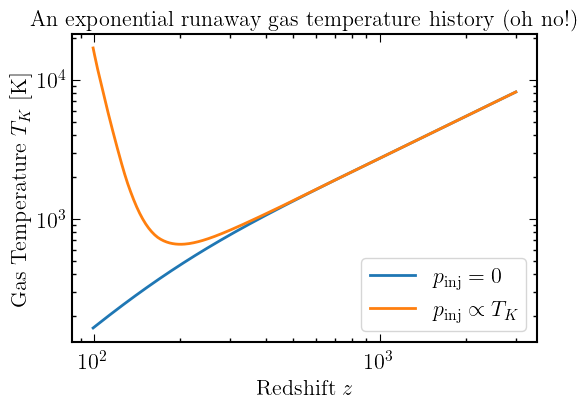

In [6]:
plt.plot(soln_base['rs']-1, (soln_base['Tm'] * u.eV / c.k_B).to(u.K), label=r'$p_\mathrm{inj}=0$')
plt.plot(soln['rs']-1, (soln['Tm'] * u.eV / c.k_B).to(u.K), label=r'$p_\mathrm{inj}\propto T_K$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Gas Temperature $ T_K$ [K]')
plt.title('An exponential runaway gas temperature history (oh no!)')
plt.legend();